## Загрузка и ознакомление с датасетом

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, normaltest
from scipy.stats import kruskal

df = pd.read_csv("D:/Загрузки/spotify-2023.csv", encoding='latin-1') 
print("Первые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())

Первые 5 строк:
                            track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA       Myke Towers             1   
2                              vampire    Olivia Rodrigo             1   
3                         Cruel Summer      Taylor Swift             1   
4                       WHERE SHE GOES         Bad Bunny             1   

   released_year  released_month  released_day  in_spotify_playlists  \
0           2023               7            14                   553   
1           2023               3            23                  1474   
2           2023               6            30                  1397   
3           2019               8            23                  7858   
4           2023               5            18                  3133   

   in_spotify_charts    streams  in_apple_playlists  ...  bpm key   mode  \
0                147  14138170

In [67]:
print("Количество пропусков по столбцам:")
print(df.isnull().sum())
print(f"\nВсего пропусков в датасете: {df.isnull().sum().sum()}")

Количество пропусков по столбцам:
track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
released_date            0
day_of_week              0
dtype: int64

Всего пропусков в датасете: 145


## Начнем преобразования в датасете. Преобразуем прослушивания в целочисленное значение и добавим столбец с днем недели

In [60]:
df['streams'] = pd.to_numeric(df['streams'], errors='coerce')

df.dropna(subset=['streams'], inplace=True)

# Преобразуем streams в целочисленный
df['streams'] = df['streams'].astype(int)
# Создаём копию с нужными названиями колонок и соберем дату
date_cols = df[['released_year', 'released_month', 'released_day']].copy()
date_cols.columns = ['year', 'month', 'day']
df['released_date'] = pd.to_datetime(date_cols, errors='coerce')
df['day_of_week'] = df['released_date'].dt.day_name()

## Построим распределение прослушиваний по дням недели релиза. И примем решение, какой критерий будем использовать для проверки гипотезы

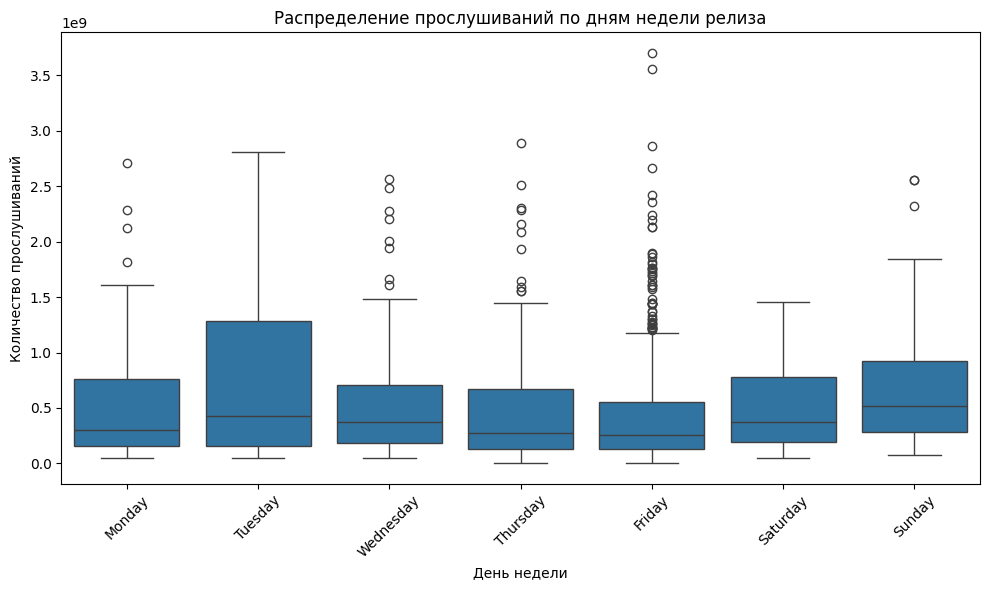

In [73]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x='day_of_week',
    y='streams',
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
plt.title('Распределение прослушиваний по дням недели релиза')
plt.ylabel('Количество прослушиваний')
plt.xlabel('День недели')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Стоит отметить, что пятница демонстрирует наибольшее количество положительных выбросов — это указывает на присутствие треков с экстремально высокими показателями стримов. Можно предположить, что именно в этот день релизы выпускают наиболее популярные артисты, чьи прослушивания значительно превышают средние значения и "затмевают" менее известных исполнителей. При этом медианное значение стримов по пятницам остаётся самым низким среди всех дней недели, что может свидетельствовать о высокой конкуренции в этот день.
Во вторник же наблюдается наиболее широкое "тело" распределения — это говорит о более равномерном и плотном распределении стримов. Кроме того, медиана во вторник находится на сравнительно высоком уровне, что делает этот день потенциально более благоприятным для релизов артистов с небольшой аудиторией**

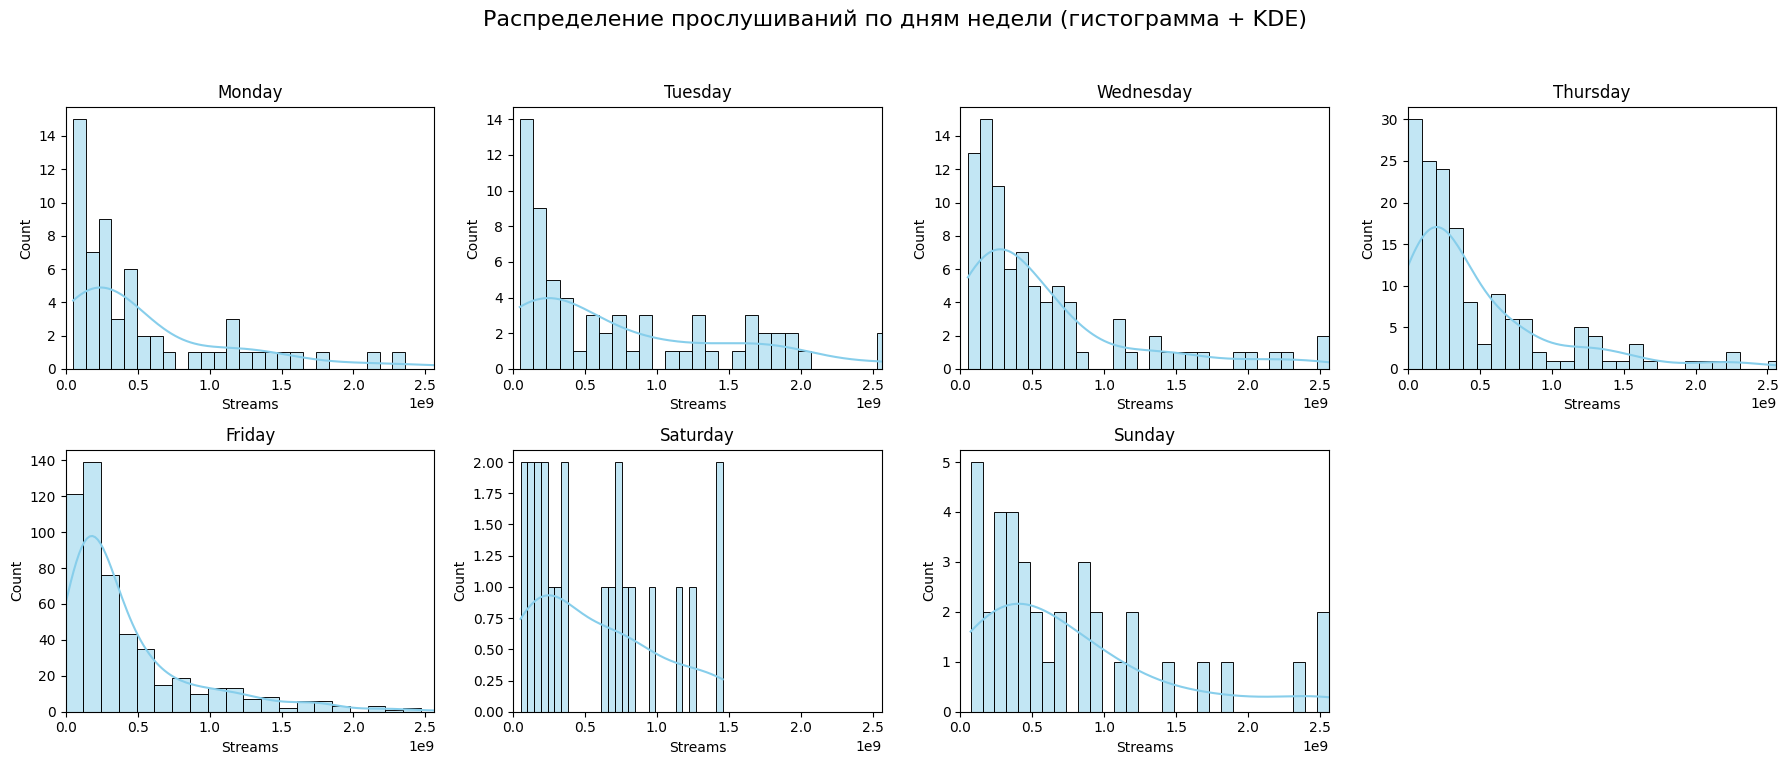

day_of_week
Monday        60
Tuesday       65
Wednesday     87
Thursday     154
Friday       526
Saturday      23
Sunday        37
Name: count, dtype: int64


In [74]:
import matplotlib.pyplot as plt

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
axes = axes.flatten()

for i, day in enumerate(days):
    ax = axes[i]
    sns.histplot(df[df['day_of_week'] == day]['streams'],
                 bins=30, kde=True, ax=ax, color='skyblue')
    ax.set_title(day)
    ax.set_xlim(0, df['streams'].quantile(0.99)) 
    ax.set_xlabel('Streams')
    ax.set_ylabel('Count')

# Отключим пустую восьмую ось
if len(axes) > 7:
    axes[7].axis('off')

plt.suptitle('Распределение прослушиваний по дням недели (гистограмма + KDE)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
group_counts = df['day_of_week'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

print(group_counts)


**Наши группы не распределены нормально, поэтому будем использовать критерий Крускала Уоллиса. Также отметим что размер выборок сильно разнится. Это нужно будет учитывать в будущем**

## Проверим, существуют ли статистически значимые различия в количестве прослушиваний между днями недели релиза с помощью критерия Краскела–Уоллиса

**Нулевая гипотеза (H₀): Количество стримов не зависит от дня недели релиза — распределения стримов по всем дням недели одинаковы**

**Альтернативная гипотеза (H₁): Существует хотя бы один день недели, для которого распределение стримов статистически значимо отличается от остальных**

In [48]:
groups = [group['streams'].dropna() for _, group in df.groupby('day_of_week')]

# Критерий Крускала–Уоллиса
h_stat, p_value = kruskal(*groups)

print(f"Критерий Крускала–Уоллиса:\nH = {h_stat:.3f}, p-value = {p_value:.5f}")


Критерий Крускала–Уоллиса:
H = 26.960, p-value = 0.00015


**p-value < 0.05, значит есть статически значимые различия. Чтобы понять какой день самый "счастливый" для релиза, рассмотрим некоторые метрики**

In [49]:
#pip install scikit_posthocs

In [50]:
import scikit_posthocs as sp

dunn_results = sp.posthoc_dunn(
    df, 
    val_col='streams', 
    group_col='day_of_week',
    p_adjust='bonferroni'
)

print(dunn_results.round(4))


           Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
Friday     1.0000     1.0       1.0  0.0075    1.0000   0.0335     0.2189
Monday     1.0000     1.0       1.0  1.0000    1.0000   1.0000     1.0000
Saturday   1.0000     1.0       1.0  1.0000    1.0000   1.0000     1.0000
Sunday     0.0075     1.0       1.0  1.0000    0.0724   1.0000     1.0000
Thursday   1.0000     1.0       1.0  0.0724    1.0000   0.4255     1.0000
Tuesday    0.0335     1.0       1.0  1.0000    0.4255   1.0000     1.0000
Wednesday  0.2189     1.0       1.0  1.0000    1.0000   1.0000     1.0000


**Видим два статически значимых различия между:**
- вторником и пятницей
- пятницей и воскресеньем

## Посмотрим, насколько часто топ-артисты делают релиз в пятницу, и что это им дает

In [75]:
# Группируем и считаем медиану
median_streams = df.groupby('day_of_week')['streams'].median()

# Сортируем по убыванию
median_streams = median_streams.sort_values(ascending=False)

# Красиво выводим
for day, value in median_streams.items():
    print(f"{day:<10}: {value:,.0f} прослушиваний (медиана)")


Sunday    : 520,034,544 прослушиваний (медиана)
Tuesday   : 429,829,812 прослушиваний (медиана)
Wednesday : 374,191,487 прослушиваний (медиана)
Saturday  : 372,476,382 прослушиваний (медиана)
Monday    : 305,484,435 прослушиваний (медиана)
Thursday  : 278,424,827 прослушиваний (медиана)
Friday    : 253,934,790 прослушиваний (медиана)


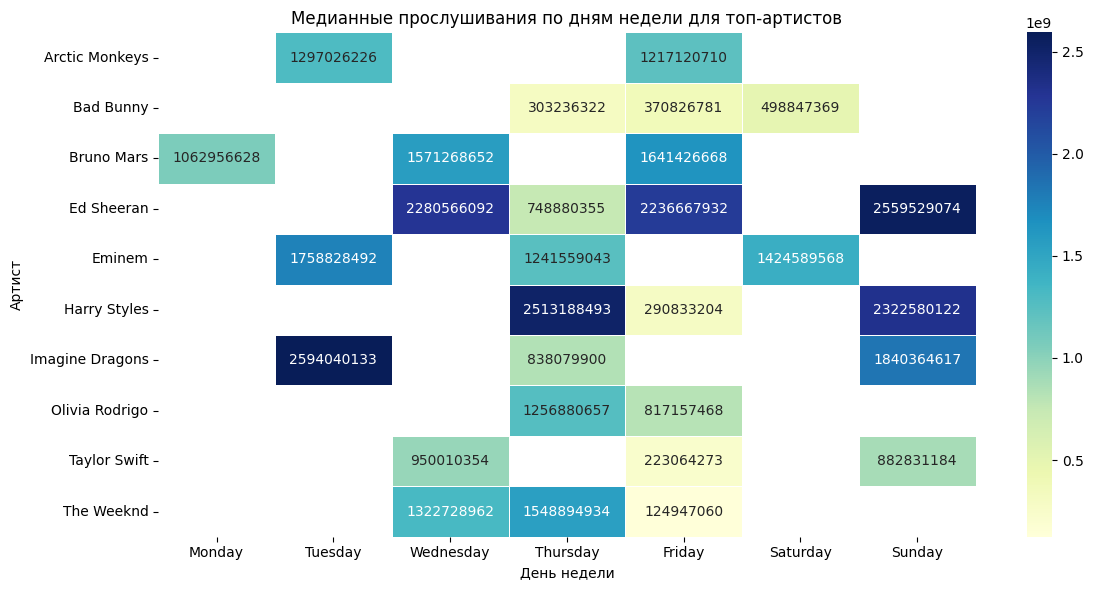

In [76]:
# Топ-10 артистов по суммарным стримам
top_artists = df.groupby("artist(s)_name")["streams"].sum().sort_values(ascending=False).head(10).index

# Отфильтруем только треки этих артистов
top_df = df[df["artist(s)_name"].isin(top_artists)]

# Группировка: артист × день недели → медиана стримов
heatmap_data = top_df.groupby(["artist(s)_name", "day_of_week"])["streams"].median().unstack()


day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data = heatmap_data[day_order]

# Визуализация
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)
plt.title("Медианные прослушивания по дням недели для топ-артистов")
plt.xlabel("День недели")
plt.ylabel("Артист")
plt.tight_layout()
plt.show()


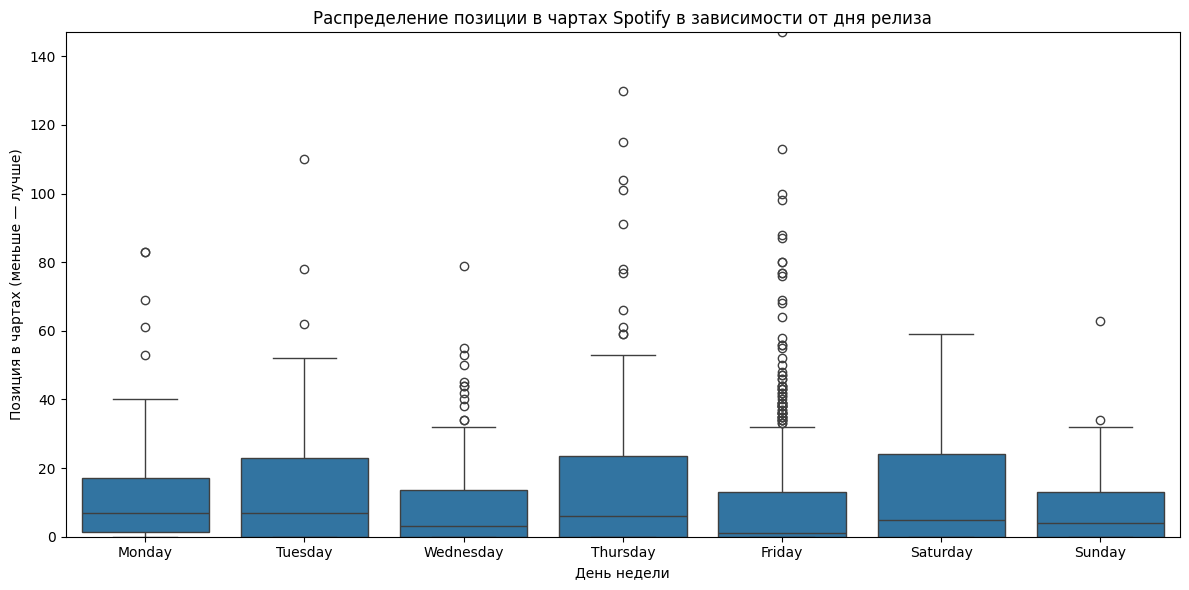

In [53]:

charts_df = df.dropna(subset=["in_spotify_charts"]).copy()
plt.figure(figsize=(12, 6))
sns.boxplot(data=charts_df, x="day_of_week", y="in_spotify_charts", order=[
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
])
plt.ylim(0, charts_df["in_spotify_charts"].max())  
plt.title("Распределение позиции в чартах Spotify в зависимости от дня релиза")
plt.ylabel("Позиция в чартах (меньше — лучше)")
plt.xlabel("День недели")
plt.tight_layout()
plt.show()

In [54]:
charts_df = df.dropna(subset=["in_spotify_charts"]).copy()
median_positions = charts_df.groupby("day_of_week")["in_spotify_charts"].median()
median_positions = median_positions.reindex(day_order)
print("Медианные позиции в чартах Spotify по дню недели релиза:")
for day, value in median_positions.items():
    print(f"{day:<10}: {value:.0f}")

Медианные позиции в чартах Spotify по дню недели релиза:
Monday    : 7
Tuesday   : 7
Wednesday : 3
Thursday  : 6
Friday    : 1
Saturday  : 5
Sunday    : 4


**Видим, что медианное значение релизов в пятницу соответствует первому месту. Удивительный результат, но учитывая, что датасет содержит хиты,
то такое вполне может быть**

## Возможно еще колчиество прослушиваний зависит от месяца релиза. Посмотрим количество прослушиваний по месяцу и дню релиза

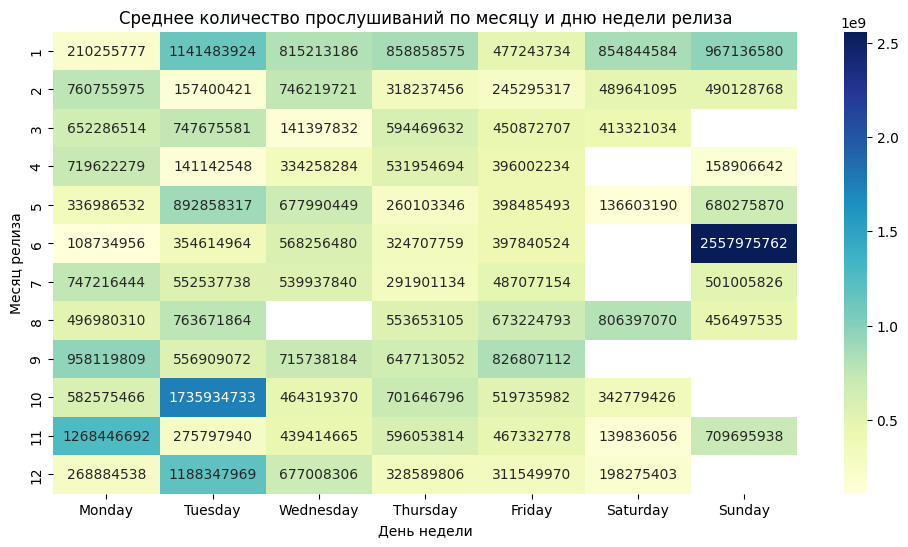

In [55]:
# Группируем и считаем средние прослушивания
pivot_table = df.pivot_table(index='released_month', columns='day_of_week', values='streams', aggfunc='mean')
pivot_table = pivot_table[day_order]

plt.figure(figsize=(12,6))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title('Среднее количество прослушиваний по месяцу и дню недели релиза')
plt.xlabel('День недели')
plt.ylabel('Месяц релиза')
plt.show()

**Вторник чаще других дней были результаты выше среднего, при этом не имеет пропусков в отличие от воскресенья.
То есть артисты ежемесячно выбирают вторник для релиза**

## Далее я хотел просто убедиться, что самые популярные артисты(с наибольшей долей прослушиваний) выбирают пятницу для релиза

In [56]:
df_artist = df.groupby('artist(s)_name')['streams'].sum().reset_index()

# Считаем общее количество стримов и долю каждого артиста
total_streams = df_artist['streams'].sum()
df_artist['share_percent'] = (df_artist['streams'] / total_streams) * 100
df_artist['share_percent'] = df_artist['share_percent'].round(2)
top10 = df_artist.sort_values(by='streams', ascending=False).head(10)
print(top10[['artist(s)_name', 'streams', 'share_percent']])

      artist(s)_name      streams  share_percent
571       The Weeknd  14185552870           2.90
557     Taylor Swift  14053658300           2.87
159       Ed Sheeran  13908947204           2.84
222     Harry Styles  11608645649           2.37
43         Bad Bunny   9997799607           2.04
430   Olivia Rodrigo   7442148916           1.52
170           Eminem   6183805596           1.26
75        Bruno Mars   5846920599           1.19
25    Arctic Monkeys   5569806731           1.14
228  Imagine Dragons   5272484650           1.08


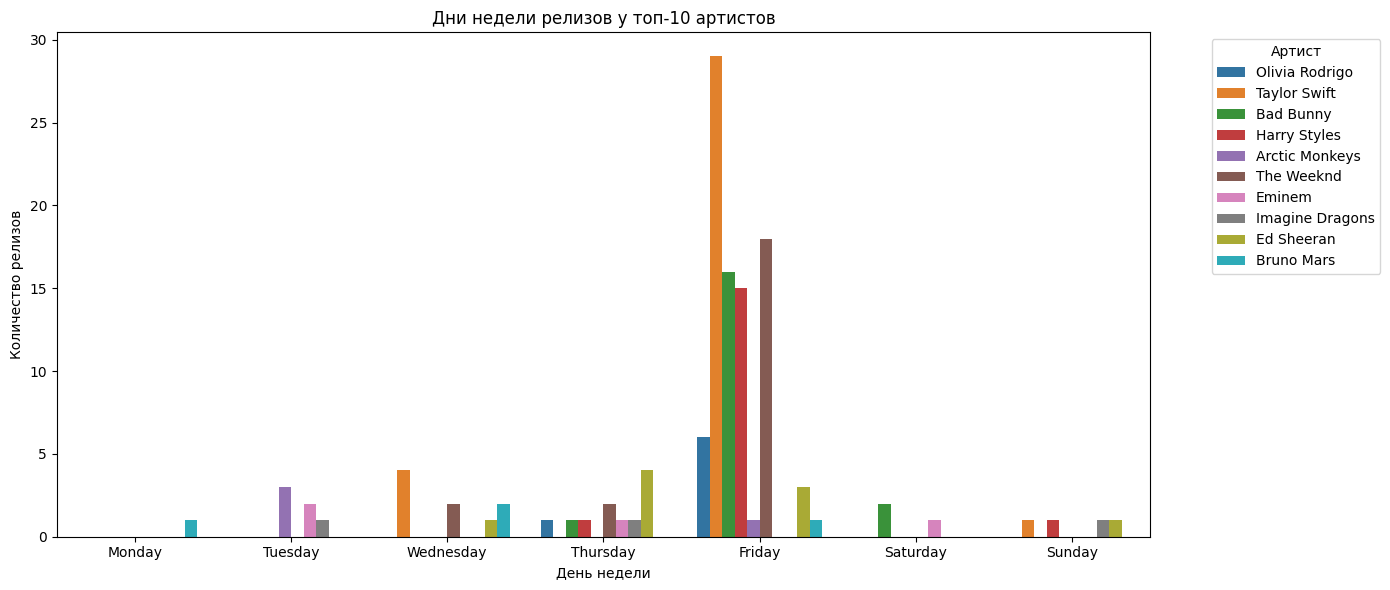

In [77]:
top10_artists = top10['artist(s)_name'].tolist()
df_top_releases = df[df['artist(s)_name'].isin(top10_artists)]

plt.figure(figsize=(14,6))
sns.countplot(
    data=df_top_releases,
    x='day_of_week',
    hue='artist(s)_name',
    order=day_order
)

plt.title('Дни недели релизов у топ-10 артистов')
plt.xlabel('День недели')
plt.ylabel('Количество релизов')
plt.legend(title='Артист', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Ожидание подтвердилось, топ-артисты выбирают чаще всего пятницу для релиза** 

Итого: 
- Пятничные релизы достигают самых высоких позиций в чартах: медианная позиция — 1.
  
- На выходных значительно возрастает активность пользователей стриминговых платформ — слушатели чаще ищут и слушают новые треки.

  
- Пятница является международным стандартом для музыкальных премьер, и аудитория ожидает новинки именно в этот день.

- В пятницу обновляются чарты
  
- Вторник занимает второе место по медианному количеству прослушиваний среди всех дней недели (первое — воскресенье).

- Конкуренция среди релизов во вторник заметно ниже, чем в пятницу, что повышает шансы на рост прослушиваний

- Распределение прослушиваний во вторник более плотное вблизи средних значений, с меньшим числом выбросов по сравнению с воскресеньем — это делает результаты более предсказуемыми.

- Объём выборки треков, выпущенных во вторник, почти в два раза превышает воскресную, что повышает надёжность статистических выводов.

## Вывод: 
**Для топ-артиста с широкой аудиторией наилучшим днём для релиза является пятница — в этот день обновляются чарты, аудитория наиболее активна, а алгоритмы стриминговых платформ заточены под глобальный цикл новинок.**

**Если вы независимый артист или только наращиваете аудиторию, оптимальным днём станет вторник — ниже конкуренция, выше медианные прослушивания и шанс удержать внимание слушателя.**
